In [1]:
!pip install shap
!pip install pyale
!pip install git+https://github.com/blent-ai/ALEPython
!pip install xgboost
!pip install git+https://github.com/christophM/rulefit.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.6 MB/s eta 0:00:00
  Cloning https://github.com/blent-ai/ALEPython to /tmp/pip-req-build-4mhha8tw
  Running command git clone --filter=blob:none --quiet https://github.com/blent-ai/ALEPython /tmp/pip-req-build-4mhha8tw
  Resolved https://github.com/blent-ai/ALEPython to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.0 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=c782763522ef5864afe0b655e2b0acffc88959ed1aff535168965b3da1721e7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vd_ztcm6/wheels/b6/b6/22/e1ae434298d710b42c8b4d1dcdb31f8d62e8818df5ad0c666c
Successfully built alepython
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-req-build-eztdi4ec
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulef

In [2]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
from scipy.stats import spearmanr  # Add this import
from alibi.explainers.ale import ALE
from alepython import ale_plot
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tensorflow.keras.layers import Input, Dense, Normalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from rulefit import RuleFit
from sklearn.tree import plot_tree
import seaborn as sns


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [5]:
from google.colab import drive

drive.mount('/content/drive')

MessageError: ignored

In [6]:
# Read data from CSV
data = pd.read_csv('fueleconomy.csv', delimiter=';')

In [7]:
for col in data.columns:
    print(col)


Year
Manufacturer
Model
barrels08
barrelsA08
charge120
charge240
city08
city08U
cityA08
cityA08U
cityCD
cityE
cityUF
co2
co2A
co2TailpipeAGpm
co2TailpipeGpm
comb08
comb08U
combA08
combA08U
combE
combinedCD
combinedUF
cylinders
displ
drive
engId
eng_dscr
feScore
fuelCost08
fuelCostA08
fuelType
fuelType1
ghgScore
ghgScoreA
highway08
highway08U
highwayA08
highwayA08U
VClass
highwayCD
highwayE
highwayUF
hlv
hpv
id
lv2
lv4
mpgData
phevBlended
pv2
pv4
range
rangeCity
rangeCityA
rangeHwy
rangeHwyA
trany
UCity
UCityA
UHighway
UHighwayA
youSaveSpend
guzzler
trans_dscr
tCharger
sCharger
atvType
fuelType2
rangeA
evMotor
mfrCode
c240Dscr
charge240b
c240bDscr
createdOn
modifiedOn
startStop
phevCity
phevHwy
phevComb


In [8]:
X = data[['co2TailpipeGpm', 'Year', 'displ', 'co2', 'pv4', 'cylinders', 'lv4', 'hlv', 'ghgScore']]


In [9]:
print("nans: ", np.isnan(X))

nans:         co2TailpipeGpm   Year  displ    co2    pv4  cylinders    lv4    hlv  \
0               False  False  False  False  False      False  False  False   
1               False  False  False  False  False      False  False  False   
2               False  False  False  False  False      False  False  False   
3               False  False  False  False  False      False  False  False   
4               False  False  False  False  False      False  False  False   
...               ...    ...    ...    ...    ...        ...    ...    ...   
45891           False  False  False  False  False      False  False  False   
45892           False  False  False  False  False      False  False  False   
45893           False  False  False  False  False      False  False  False   
45894           False  False  False  False  False      False  False  False   
45895           False  False  False  False  False      False  False  False   

       ghgScore  
0         False  
1         False  
2 

In [10]:
# Use only 100 samples
data_sample = data.sample(100, random_state=42)

In [11]:
# Define X and y
X = data_sample.drop('comb08', axis=1)  # Assuming comb08 is the target variable
y = data_sample['comb08']

In [12]:
# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [13]:
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [15]:
# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


In [16]:
# Train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Initialize shap.TreeExplainer
explainer = shap.TreeExplainer(rf_classifier)

In [18]:
# Calculate Shapley values for the test set
shap_values = explainer.shap_values(X_test)

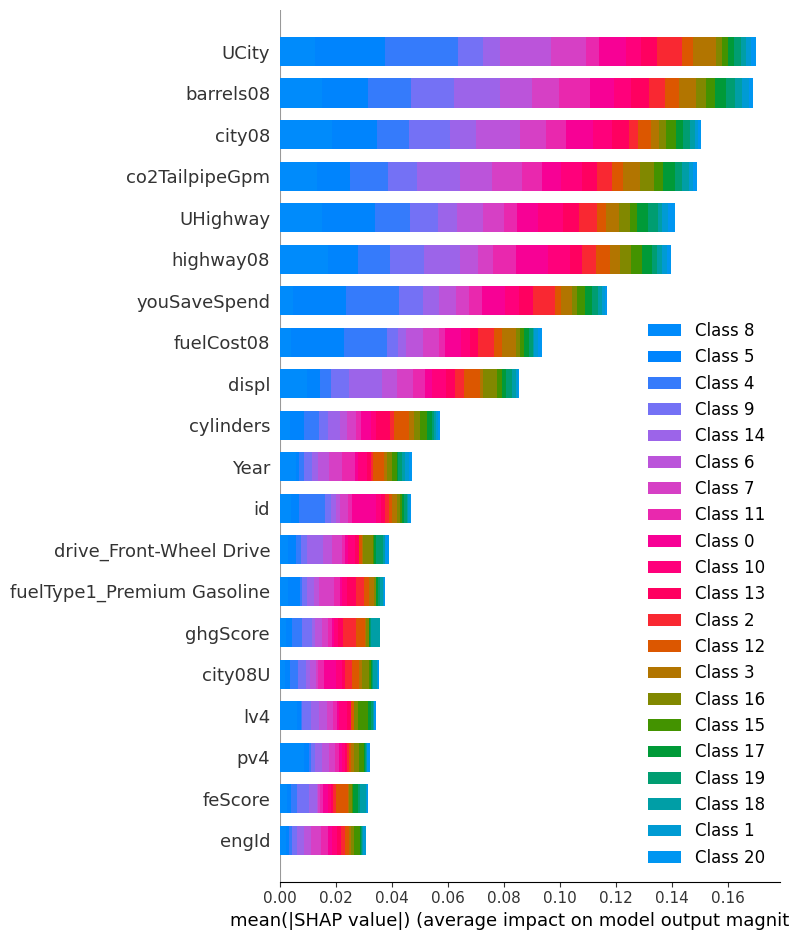

In [19]:
# Plot the Shapley summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

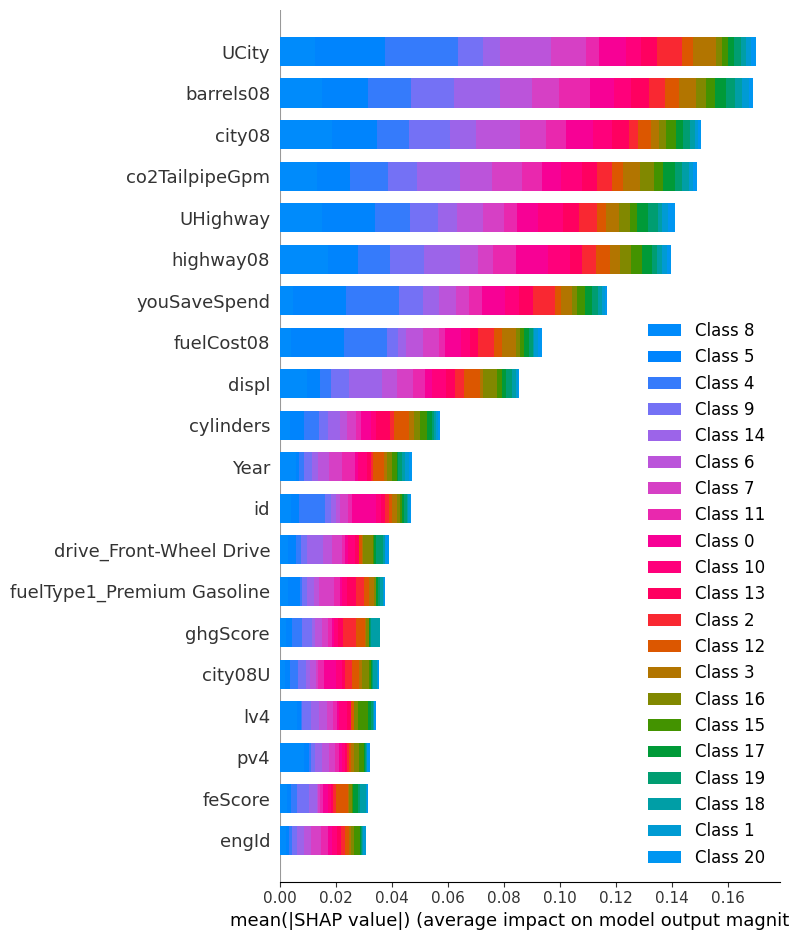

In [ ]:

# Plot the feature correlation
shap.summary_plot(shap_values, X_test)

In [20]:
# Make predictions on training and test sets
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

In [24]:
# Plot Mean Square Error of train and test data
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

In [25]:
# Plot r2 score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [23]:
# Print results
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

print(f"R2 Score (Train): {r2_train}")
print(f"R2 Score (Test): {r2_test}")

# Display the plots
plt.show()

Mean Squared Error (Train): 0.0
Mean Squared Error (Test): 1.9
R2 Score (Train): 1.0
R2 Score (Test): 0.9376793767937679


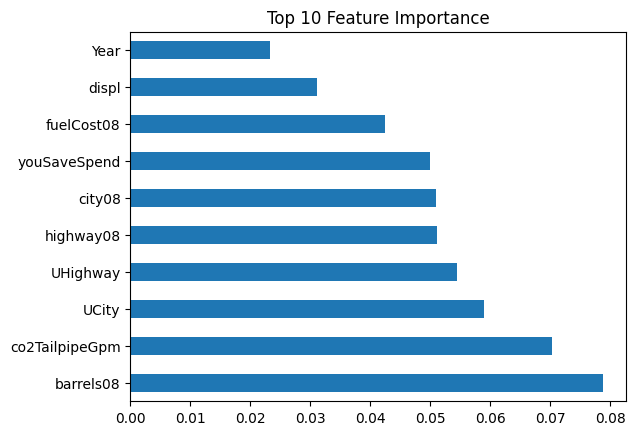

In [26]:
# Plot feature importance as bar chart
feature_importance = pd.Series(rf_classifier.feature_importances_, index=X_encoded.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importance")
plt.show()

In [27]:
# Test the spearman correlation hypothesis between co2 and Year
spearman_corr, spearman_pvalue = spearmanr(data_sample['co2'], data_sample['Year'])
print(f"Spearman Correlation between co2 and Year: {spearman_corr}")
print(f"P-value: {spearman_pvalue}")

Spearman Correlation between co2 and Year: 0.7558525634312432
P-value: 9.964408245161273e-20


In [28]:
# Assuming you want to plot for the first class (change the index as needed)
class_index = 0
shap_values_class = shap_values[class_index]

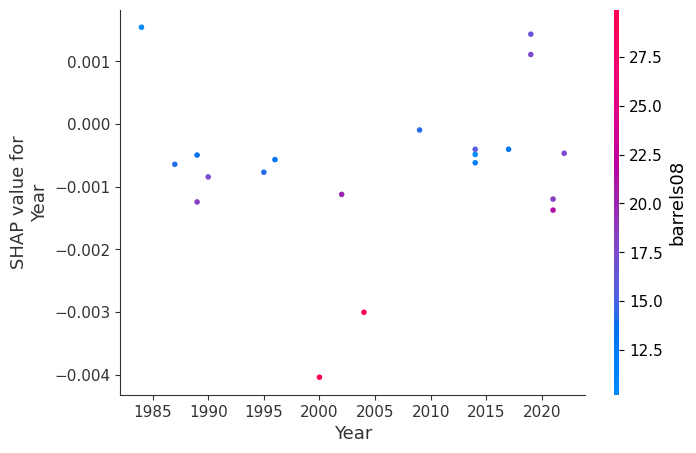

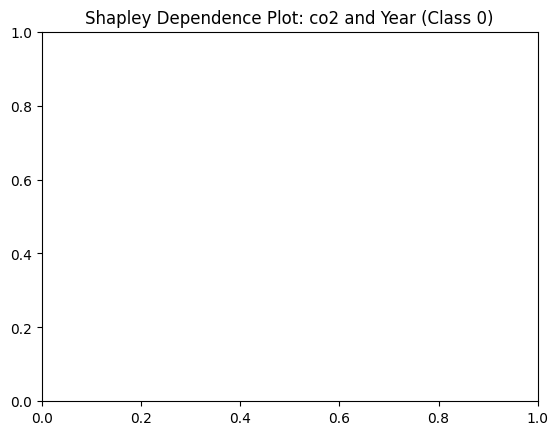

In [29]:
# Plot a Shapley dependence plot between co2 and Year
shap.dependence_plot('Year', shap_values_class, X_test)
plt.title(f"Shapley Dependence Plot: co2 and Year (Class {class_index})")
plt.show()

In [30]:
# Train a RandomForestClassifier (you can replace it with your model)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Choose the features for ALE plots
#features_to_plot = ['pv2', 'hlv', '2-door passenger volume (in cubic feet)', 'hatchback luggage volume (in cubic feet)']


In [32]:
# Check the size of X_test
print("Size of X_test:", X_test.shape)

Size of X_test: (20, 334)


In [33]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

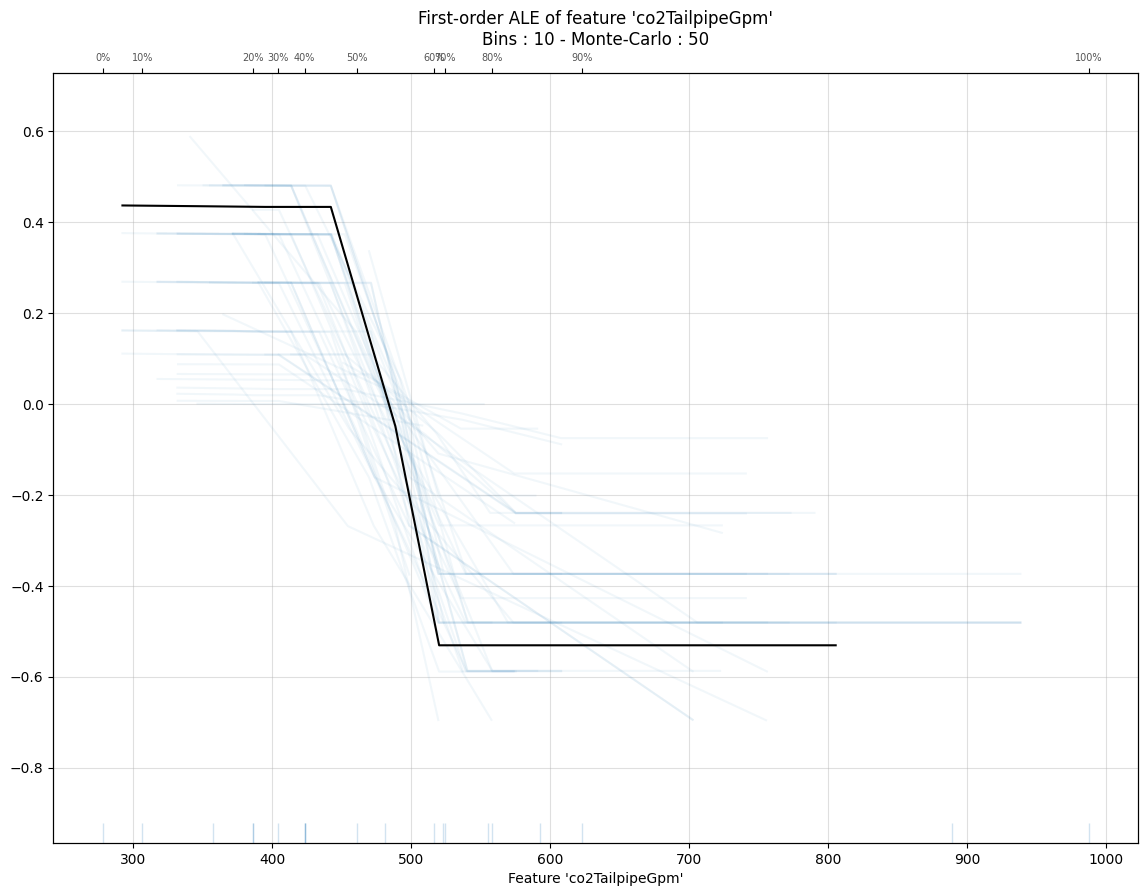

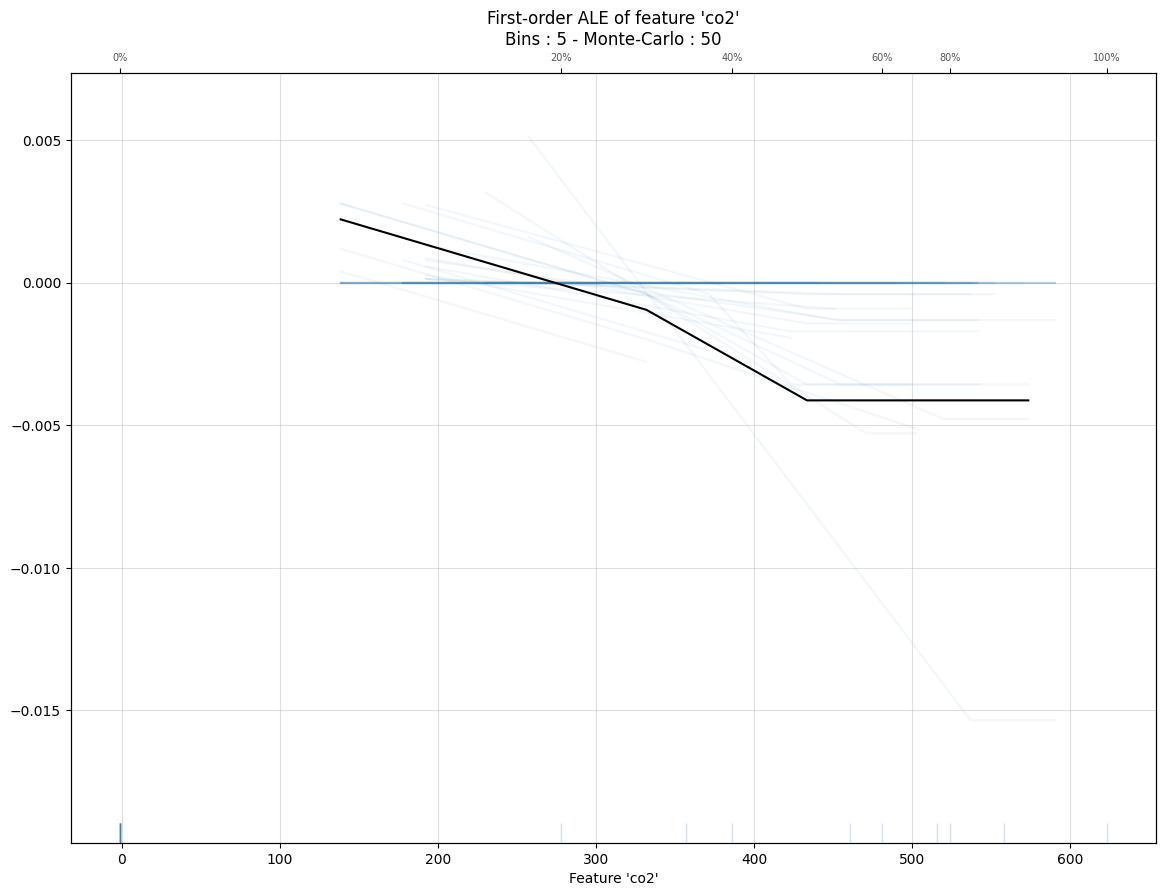

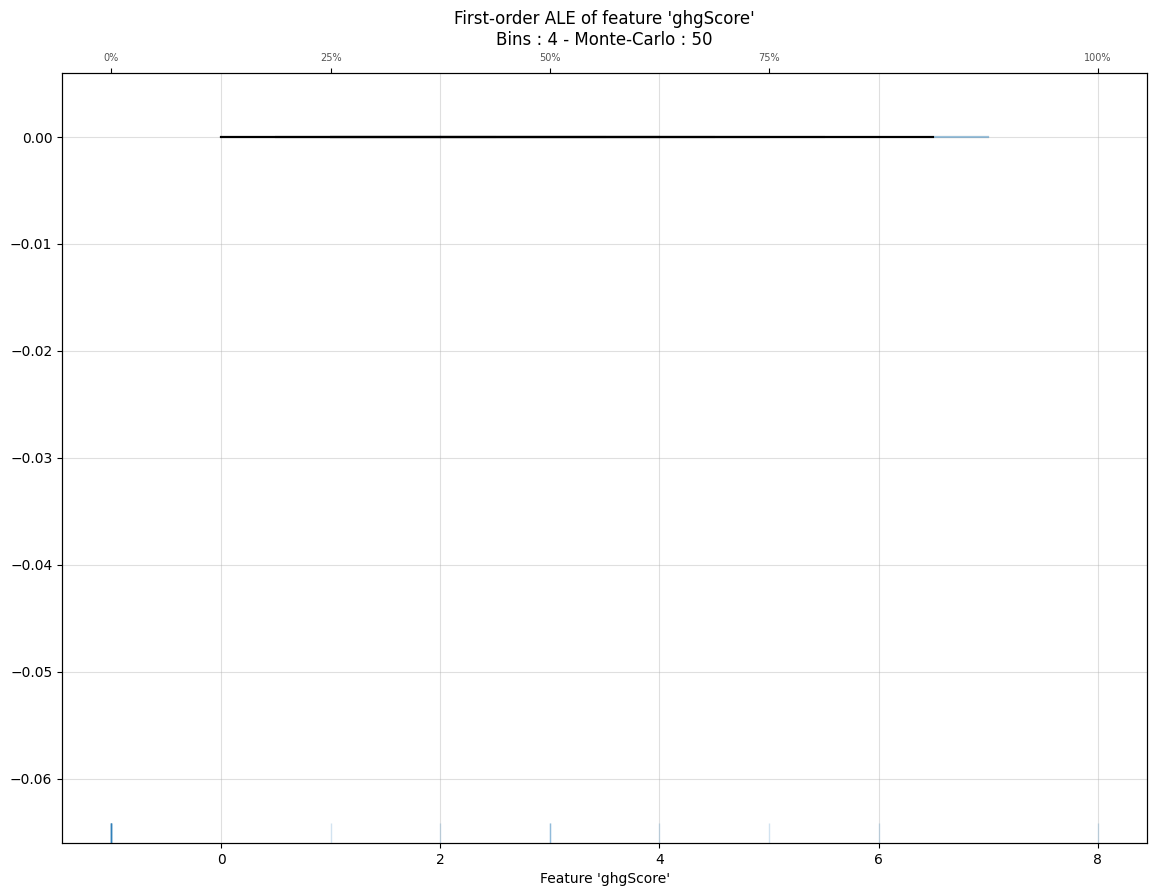

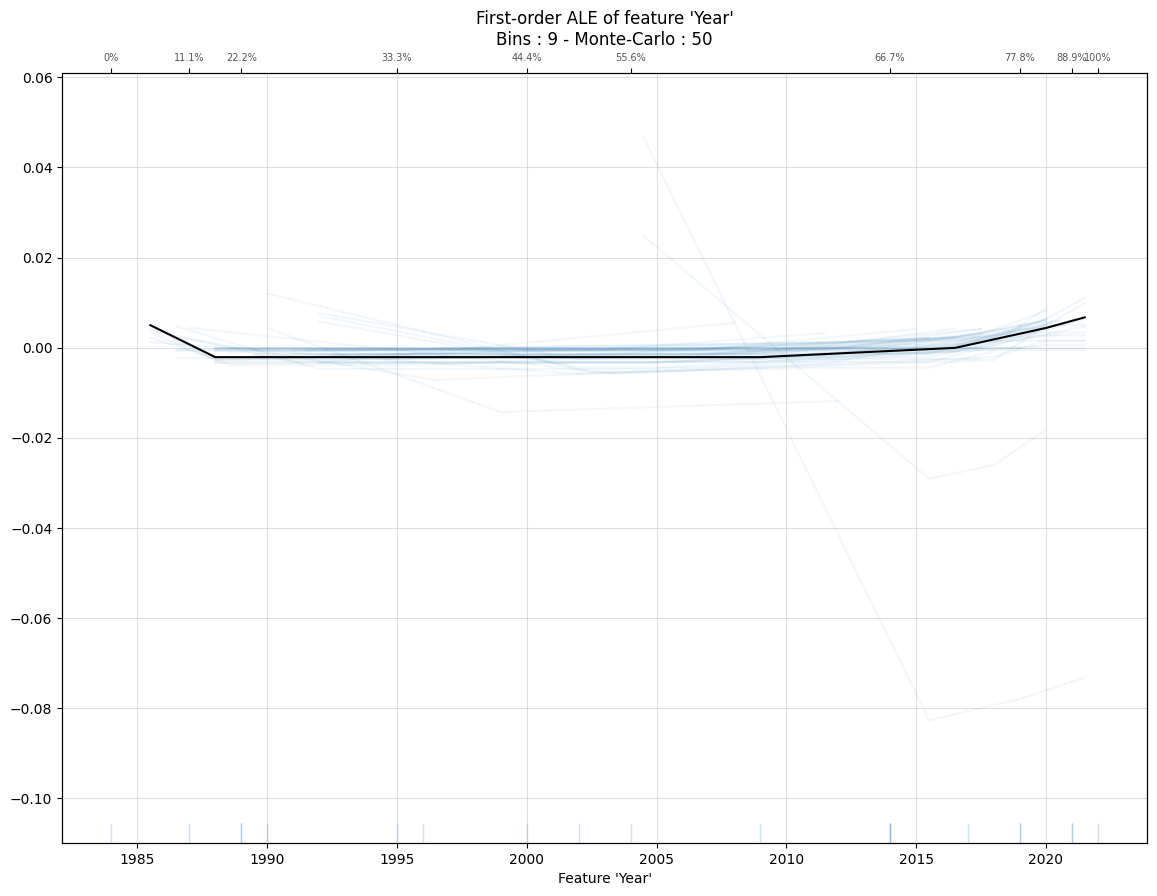

In [34]:
# Use ale_plot for each feature
for feature_name in ['co2TailpipeGpm', 'co2', 'ghgScore', 'Year']:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        xgb_model, X_test, feature_name,
        monte_carlo=True, monte_carlo_rep=50,
        monte_carlo_ratio=0.4
    )
    plt.show()

In [35]:
X = np.random.rand(100, 5)
y = np.random.rand(100, 1)

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Preprocess continuous features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Normalization

In [39]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Normalization(),  # Normalization layer for continuous features
    Dense(64, activation='relu'),
    Dense(1)
])

In [40]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [41]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
3/3 [==============================] - 3s 108ms/step - loss: 0.4364 - mae: 0.5732 - val_loss: 0.3576 - val_mae: 0.4689
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3833 - mae: 0.5370 - val_loss: 0.3164 - val_mae: 0.4423
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3396 - mae: 0.5046 - val_loss: 0.2839 - val_mae: 0.4234
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2982 - mae: 0.4704 - val_loss: 0.2589 - val_mae: 0.4143
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2669 - mae: 0.4399 - val_loss: 0.2396 - val_mae: 0.4072
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2404 - mae: 0.4128 - val_loss: 0.2251 - val_mae: 0.4000
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2184 - mae: 0.3899 - val_loss: 0.2154 - val_mae: 0.3947
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2008 - mae: 0.3

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

1/1 [==============================] - 0s 24ms/step - loss: 0.1298 - mae: 0.3006
Test Loss: 0.12977288663387299, Test MAE: 0.3006435036659241


In [ ]:
# Train Decision Tree surrogate
dt_surrogate = DecisionTreeRegressor()
dt_surrogate.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [ ]:
# Predictions on test set
dt_predictions = dt_surrogate.predict(X_test_scaled)

# Compute RMSE
dt_rmse = mean_squared_error(y_test, dt_predictions, squared=False)
print(f'Decision Tree RMSE: {dt_rmse}')

Decision Tree RMSE: 0.40672634769782984


In [ ]:
# Create RuleFit surrogate with a specific max_iter value
rf_surrogate = RuleFit(max_iter=1000, model_type='regressor', max_rules=100)
rf_surrogate.fit(X_train_scaled, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

RuleFit(max_iter=1000, max_rules=100, model_type='regressor',
        tree_generator=GradientBoostingRegressor(learning_rate=0.01,
                                                 max_depth=100,
                                                 max_leaf_nodes=5,
                                                 n_estimators=29,
                                                 random_state=28,
                                                 subsample=0.5))

In [ ]:
rf_surrogate = RuleFit(max_iter=1000)
rf_surrogate.fit(X_train_scaled, y_train)
# Predictions on test set
rf_predictions = rf_surrogate.predict(X_test_scaled)

# Predictions on test set
rf_predictions = rf_surrogate.predict(X_test_scaled)

# Compute RMSE
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
print(f'RuleFit RMSE: {rf_rmse}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

RuleFit RMSE: 0.3416040226354714


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.511e-04, tolerance: 5.273e-04


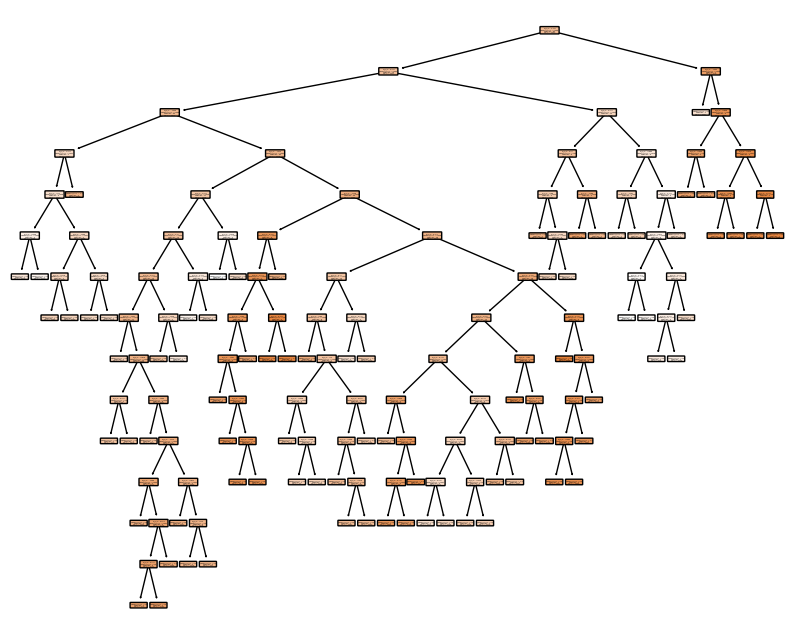

In [ ]:
# Plot Decision Tree without specifying feature_names
plt.figure(figsize=(10, 8))
plot_tree(dt_surrogate, filled=True, rounded=True)
plt.show()


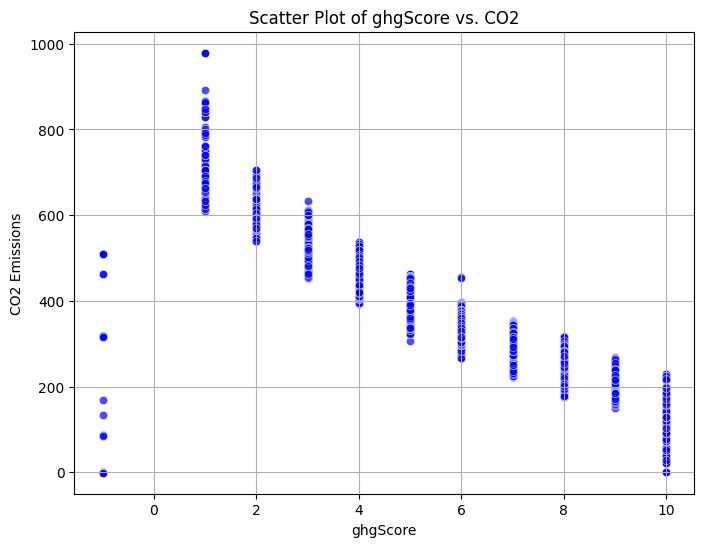

In [ ]:
# Specify the columns of interest, How can you explain correlation between
#ghgScore and co2?
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ghgScore', y='co2', data=data, color='blue', alpha=0.7)
plt.title('Scatter Plot of ghgScore vs. CO2')
plt.xlabel('ghgScore')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.show()